# Import necessary packages

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from skimage.io import imshow
from skimage.transform import resize
# from skimage.morphology import label
# from skimage.feature import structure_tensor
from sklearn.model_selection import train_test_split
# from PIL import Image, ImageDraw
import cv2

import tensorflow as tf

from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [ ]:
# Problem:
# Robustness of the model and transferability, because of different acquisition and muscles and setting on the ultrasound devices
# Test if area estimation makes sense when measured if completely automated 


## Define custom functions

In [2]:
# Convolution block
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), \
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

# Create u-net model
def get_unet(input_img, n_filters = 64, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    
    # Contracting Path
    # c is output tensor of conv layers
    # p ist output tensor of max pool layers
    # u is output tensor of up-sampling (transposed) layers
    # Batchnorm standardizes/normalizes the output of each layer where applied in order to avoid huge weights using 
    # z-scores 
    
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

# Compute Intersection over union (IoU), a measure of labelling accuracy
# NOTE: This is sometimes also called Jaccard score
def IoU(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
    iou = (intersection + smooth) / ( union + smooth)
    return iou

## APONEUROSIS TRAINING

# Set image scaling parameters, determine no. of images for training

In [3]:
# Images will be re-scaled
im_width = 512
im_height = 512
border = 5

# list of all images in the path
#ids = next(os.walk("apo_images"))[2] 
ids = next(os.walk("apo_image_csa"))[2] 
print("Total no. of aponeurosis images = ", len(ids))
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

Total no. of aponeurosis images =  42


# Load images and corresponding labels (masks)

In [4]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img("apo_image_csa/"+id_, color_mode='grayscale')
    x_img = img_to_array(img)
    x_img = resize(x_img, (512, 512, 1), mode = 'constant', preserve_range = True)
    # Load masks
    #mask = img_to_array(load_img("apo_masks/"+id_, color_mode='grayscale'))
    mask = img_to_array(load_img("apo_masks_csa/"+id_, color_mode='grayscale'))
    mask = resize(mask, (512, 512, 1), mode = 'constant', preserve_range = True)
    # Normalise and store images
    X[n] = x_img/255.0
    y[n] = mask/255.0

c:\users\paul\miniconda3\envs\dl_track\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


# Set up aponeurosis training

In [5]:
# Split data into training and validation
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1) # i.e. 90% training / 10% test split

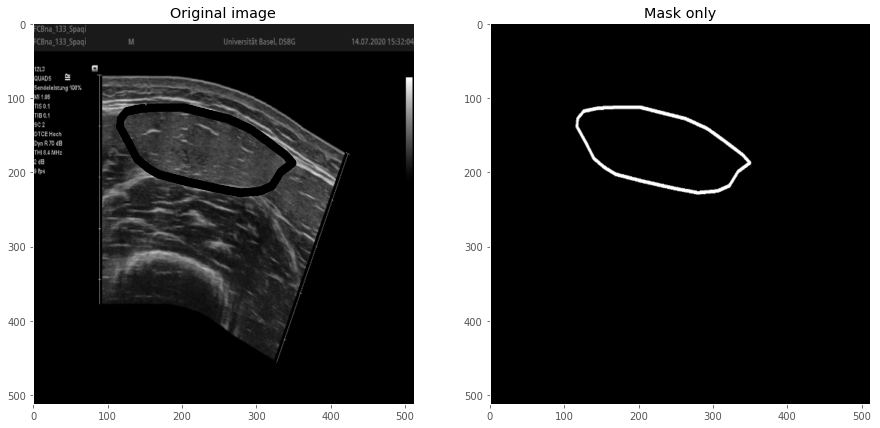

In [77]:
# Visualize a random image along with the mask (not necessary, just for checking)
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # Check whether there's at least 1 aponeurosis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 12))
ax1.imshow(X_train[ix, ..., 0], cmap = 'gray', interpolation = 'bilinear')
if has_mask: # if at least 1 aponeurosis is present
    #draw the aponeuroses on the original image
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
    ax1.set_title('Original image')
    ax1.grid(False)
    ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
    ax2.set_title('Mask only')
    ax2.grid(False)

In [7]:
# Compile the aponeurosis model
input_img = Input((im_height, im_width, 1), name='img')
model_apo = get_unet(input_img, n_filters=64, dropout=0.25, batchnorm=True)
model_apo.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy", IoU])

In [8]:
# Show a summary of the model structure
model_apo.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 64) 640         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 512, 512, 64) 256         conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 512, 512, 64) 0           batch_normalization_2[0][0]      
__________________________________________________________________________________________________
max_poolin

In [9]:
# Set some training parameters
# Saves the model, lowers learning rate if val los plateaus and performs early stopping. 
callbacks = [
    EarlyStopping(patience=8, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-acsa.h5', verbose=1, save_best_only=True, save_weights_only=False), # Give the model a name (the .h5 part)
    CSVLogger('apo2_weights.csv', separator=',', append=False)
]

# Train the aponeurosis model (keep batch size small!)

In [10]:
results = model_apo.fit(X_train, y_train, batch_size=1, epochs=20, callbacks=callbacks, validation_data=(X_valid, y_valid))

Train on 37 samples, validate on 5 samples
Epoch 1/20
37/37 [==============================] - ETA: 30:12 - loss: 0.8228 - acc: 0.6298 - IoU: 0.68 - ETA: 26:07 - loss: 0.8166 - acc: 0.4800 - IoU: 0.67 - ETA: 24:52 - loss: 0.7618 - acc: 0.5517 - IoU: 0.68 - ETA: 24:02 - loss: 0.7149 - acc: 0.6241 - IoU: 0.69 - ETA: 22:42 - loss: 0.6749 - acc: 0.6757 - IoU: 0.69 - ETA: 21:31 - loss: 0.6384 - acc: 0.7171 - IoU: 0.70 - ETA: 20:11 - loss: 0.6016 - acc: 0.7509 - IoU: 0.71 - ETA: 18:28 - loss: 0.5683 - acc: 0.7781 - IoU: 0.72 - ETA: 17:06 - loss: 0.5380 - acc: 0.8015 - IoU: 0.73 - ETA: 16:30 - loss: 0.5116 - acc: 0.8194 - IoU: 0.74 - ETA: 15:59 - loss: 0.4878 - acc: 0.8344 - IoU: 0.75 - ETA: 15:26 - loss: 0.4659 - acc: 0.8468 - IoU: 0.75 - ETA: 14:47 - loss: 0.4479 - acc: 0.8575 - IoU: 0.76 - ETA: 14:09 - loss: 0.4313 - acc: 0.8662 - IoU: 0.77 - ETA: 13:32 - loss: 0.4155 - acc: 0.8740 - IoU: 0.77 - ETA: 12:56 - loss: 0.4010 - acc: 0.8809 - IoU: 0.78 - ETA: 12:25 - loss: 0.3877 - acc: 0.8869 -

37/37 [==============================] - ETA: 13:10 - loss: 0.0518 - acc: 0.9845 - IoU: 0.97 - ETA: 12:45 - loss: 0.0458 - acc: 0.9845 - IoU: 0.97 - ETA: 12:35 - loss: 0.0441 - acc: 0.9848 - IoU: 0.97 - ETA: 12:05 - loss: 0.0439 - acc: 0.9848 - IoU: 0.97 - ETA: 11:39 - loss: 0.0447 - acc: 0.9841 - IoU: 0.97 - ETA: 11:15 - loss: 0.0427 - acc: 0.9851 - IoU: 0.97 - ETA: 11:04 - loss: 0.0421 - acc: 0.9852 - IoU: 0.97 - ETA: 10:46 - loss: 0.0412 - acc: 0.9854 - IoU: 0.97 - ETA: 10:19 - loss: 0.0386 - acc: 0.9868 - IoU: 0.97 - ETA: 9:51 - loss: 0.0387 - acc: 0.9867 - IoU: 0.9788 - ETA: 9:24 - loss: 0.0388 - acc: 0.9867 - IoU: 0.978 - ETA: 8:59 - loss: 0.0386 - acc: 0.9866 - IoU: 0.979 - ETA: 8:34 - loss: 0.0380 - acc: 0.9868 - IoU: 0.979 - ETA: 8:12 - loss: 0.0377 - acc: 0.9870 - IoU: 0.979 - ETA: 7:49 - loss: 0.0376 - acc: 0.9871 - IoU: 0.979 - ETA: 7:25 - loss: 0.0373 - acc: 0.9873 - IoU: 0.979 - ETA: 7:02 - loss: 0.0379 - acc: 0.9871 - IoU: 0.979 - ETA: 6:40 - loss: 0.0374 - acc: 0.9873 -

37/37 [==============================] - ETA: 14:11 - loss: 0.0235 - acc: 0.9880 - IoU: 0.98 - ETA: 14:11 - loss: 0.0212 - acc: 0.9906 - IoU: 0.98 - ETA: 13:32 - loss: 0.0220 - acc: 0.9902 - IoU: 0.98 - ETA: 12:56 - loss: 0.0222 - acc: 0.9900 - IoU: 0.98 - ETA: 12:28 - loss: 0.0228 - acc: 0.9896 - IoU: 0.98 - ETA: 12:02 - loss: 0.0222 - acc: 0.9901 - IoU: 0.98 - ETA: 11:42 - loss: 0.0224 - acc: 0.9898 - IoU: 0.98 - ETA: 11:21 - loss: 0.0222 - acc: 0.9899 - IoU: 0.98 - ETA: 10:59 - loss: 0.0217 - acc: 0.9901 - IoU: 0.98 - ETA: 10:35 - loss: 0.0235 - acc: 0.9897 - IoU: 0.98 - ETA: 10:11 - loss: 0.0237 - acc: 0.9896 - IoU: 0.98 - ETA: 9:48 - loss: 0.0236 - acc: 0.9896 - IoU: 0.9890 - ETA: 9:24 - loss: 0.0233 - acc: 0.9898 - IoU: 0.989 - ETA: 8:58 - loss: 0.0230 - acc: 0.9899 - IoU: 0.989 - ETA: 8:32 - loss: 0.0230 - acc: 0.9899 - IoU: 0.989 - ETA: 8:07 - loss: 0.0230 - acc: 0.9899 - IoU: 0.988 - ETA: 7:42 - loss: 0.0234 - acc: 0.9898 - IoU: 0.988 - ETA: 7:18 - loss: 0.0234 - acc: 0.9897 -

37/37 [==============================] - ETA: 11:29 - loss: 0.0133 - acc: 0.9934 - IoU: 0.99 - ETA: 11:09 - loss: 0.0137 - acc: 0.9930 - IoU: 0.99 - ETA: 10:51 - loss: 0.0131 - acc: 0.9933 - IoU: 0.99 - ETA: 10:34 - loss: 0.0138 - acc: 0.9928 - IoU: 0.99 - ETA: 10:23 - loss: 0.0156 - acc: 0.9920 - IoU: 0.99 - ETA: 10:01 - loss: 0.0152 - acc: 0.9924 - IoU: 0.99 - ETA: 9:40 - loss: 0.0153 - acc: 0.9923 - IoU: 0.9929 - ETA: 9:20 - loss: 0.0152 - acc: 0.9924 - IoU: 0.992 - ETA: 9:00 - loss: 0.0157 - acc: 0.9921 - IoU: 0.992 - ETA: 8:40 - loss: 0.0157 - acc: 0.9920 - IoU: 0.992 - ETA: 8:24 - loss: 0.0161 - acc: 0.9919 - IoU: 0.992 - ETA: 8:04 - loss: 0.0164 - acc: 0.9917 - IoU: 0.992 - ETA: 7:44 - loss: 0.0163 - acc: 0.9917 - IoU: 0.992 - ETA: 7:24 - loss: 0.0163 - acc: 0.9917 - IoU: 0.992 - ETA: 7:05 - loss: 0.0167 - acc: 0.9916 - IoU: 0.992 - ETA: 6:45 - loss: 0.0166 - acc: 0.9916 - IoU: 0.992 - ETA: 6:28 - loss: 0.0165 - acc: 0.9916 - IoU: 0.992 - ETA: 6:08 - loss: 0.0166 - acc: 0.9916 -

## Visualise the results of training

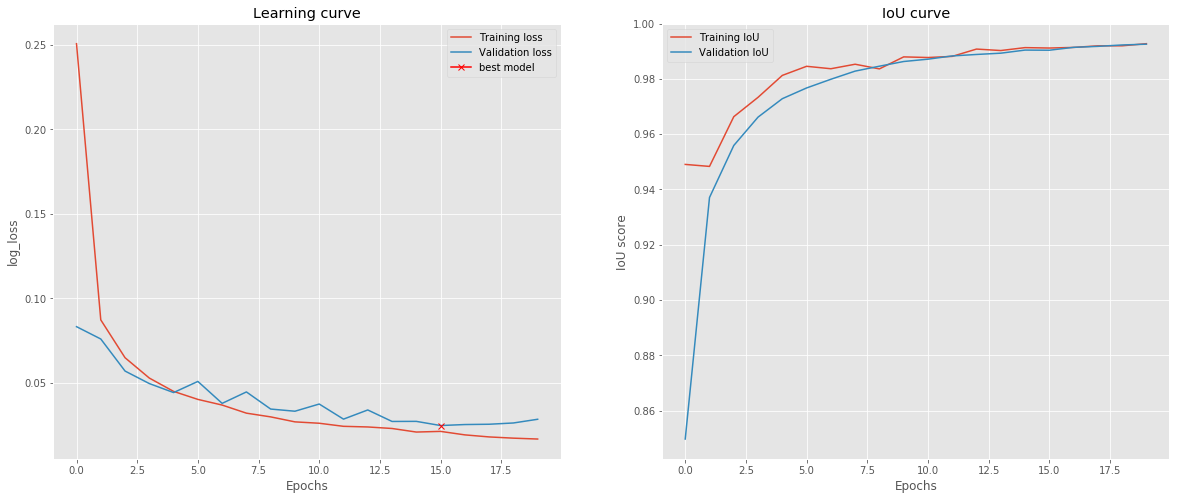

In [11]:
# Variables stored in results.history: val_loss, val_acc, val_IoU, loss, acc, IoU, lr
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].plot(results.history["loss"], label="Training loss")
ax[0].plot(results.history["val_loss"], label="Validation loss")
ax[0].set_title('Learning curve')
ax[0].plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("log_loss")
ax[0].legend();

ax[1].plot(results.history["val_IoU"], label="Training IoU")
ax[1].plot(results.history["IoU"], label="Validation IoU")
ax[1].set_title("IoU curve")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("IoU score")
ax[1].legend();

In [12]:
results.history # Show the loss values (these are saved to a .csv file using 'CSVLogger' callback defined above)

{'val_loss': [0.08322867155075073,
  0.0759280651807785,
  0.05694318413734436,
  0.049536685645580295,
  0.04420882686972618,
  0.05080204904079437,
  0.03781260624527931,
  0.044581563025712964,
  0.03444148600101471,
  0.03316118009388447,
  0.03741617500782013,
  0.028478194773197175,
  0.03390850909054279,
  0.02710386998951435,
  0.02715325020253658,
  0.0246886033564806,
  0.025272860750555994,
  0.025449755787849426,
  0.026198290288448334,
  0.028397667780518533],
 'val_acc': [0.98031005859375,
  0.9838577270507812,
  0.9847213745117187,
  0.9844955444335938,
  0.9857315063476563,
  0.9863784790039063,
  0.9858680725097656,
  0.9858116149902344,
  0.9869911193847656,
  0.9875724792480469,
  0.9861137390136718,
  0.9881942749023438,
  0.987725830078125,
  0.9886276245117187,
  0.9889396667480469,
  0.9890274047851563,
  0.9889686584472657,
  0.9893119812011719,
  0.9895088195800781,
  0.9895538330078125],
 'val_IoU': [0.9490748167037963,
  0.9483500361442566,
  0.96633491516113

In [13]:
# Predict on training and validations sets
preds_train = model_apo.predict(X_train, verbose=1)
preds_val = model_apo.predict(X_valid, verbose=1)
 
# Threshold predictions (only keep predictions with a minimum level of confidence)
# Value between 0 and 1 for each pixel. 0.5 as threshold to decide wheter to classify pixel as 0 or 1 (1=apo)
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)



5/5 [==============================] - 26s 5s/step


In [52]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='Greys_r')
    #if has_mask:
    #    ax[0].contour(y[ix].squeeze(), colors='w', levels=[0.5])
    ax[0].set_title('US-image')
    ax[0].grid(False)

    ax[1].imshow(y[ix].squeeze(), cmap='Greys_r')
    ax[1].set_title('Aponeurosis')
    ax[1].grid(False)

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1, cmap="Greys_r")
    #if has_mask:
    #    ax[2].contour(y[ix].squeeze(), colors='w', levels=[0.5])
    ax[2].set_title('Apo-Predicted')
    ax[2].grid(False)
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=0.5, cmap="Greys_r")
    #if has_mask:
    #    ax[3].contour(y[ix].squeeze(), colors='w', levels=[0.5])
    ax[3].set_title('Apo-Picture binary')
    ax[3].grid(False)

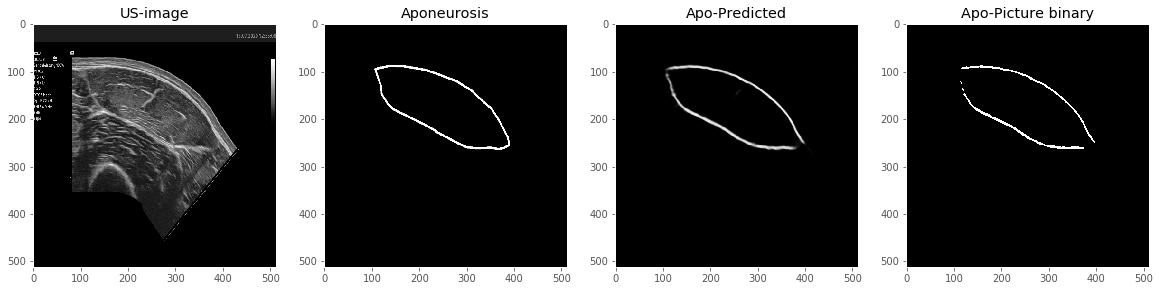

In [74]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=None)

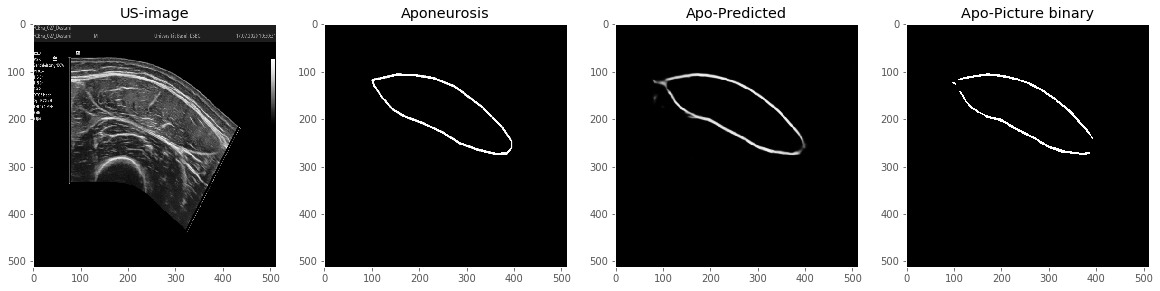

In [81]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=None)